# ETF Portfolio Optimisation
This module:
- processes historical performance of hand-picked ETFs from Yahoo Finance,
- unifies the data by converting it to Polish Zloty,
- assess the expected return and volatility of the current portfolio,
- optimises an ETF portfolio using the PyPortfolioOpt (`pypfopt`) package.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
START_DATE = date(2001, 1, 1)
END_DATE = date(2023, 12, 31)

Data gets downloaded manually from the Yahoo! Finance's API with the help of `yfinance`` package. There is data for both the ETF ratings in their issue currency as well as for the exchange rates. The exchange rate that everything will be recalculated into is Polish Zloty (PLN).

In [3]:
def download_from_yahoo_finance(tickers, start=START_DATE, end=END_DATE):
    yahoo_finance_data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
    )["Adj Close"]

    return yahoo_finance_data

In [4]:
etf_df = download_from_yahoo_finance(
    tickers=[
        "AEEM.PA",
        "PHPM.L",
        "SGLN.L",
        "SPYD.DE",
        "STNX.SW",
        "SWDA.L",
        "XDWH.DE",
        "BRNT.L",
        "XLKQ.L",
        "NICK.L",
        "COPA.L",
        "AIGI.L",
    ]
)

exchange_rates_df = download_from_yahoo_finance(
    tickers=[
        "CHFPLN=X",
        "GBPPLN=X",
        "EURPLN=X",
        "PLN=X",
    ]
)

[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  4 of 4 completed


[Text(0.5, 1.0, 'Exchange rates to PLN'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price of currency in PLN')]

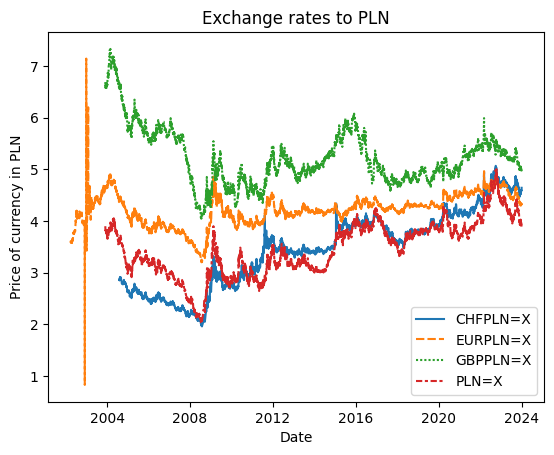

In [5]:
plot = sns.lineplot(data=exchange_rates_df)
plot.set(
    title="Exchange rates to PLN", xlabel="Date", ylabel="Price of currency in PLN"
)

There is something weird going on with the EUR to PLN plot around 2002-2003, but let's ignore this for now. This period will fall out of the analysis anyways.

Keep in mind that the weirdly labeled `PLN=X` item stands for the USD to PLN exchange rate. The name comes from the label on the Yahoo Finance website.

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions. These need to be included as well.

In [6]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1],
    "AEEM.PA": ["EURPLN=X", 1],
    "XDWH.DE": ["EURPLN=X", 1],
    "BRNT.L": ["PLN=X", 1],
    "XLKQ.L": ["GBPPLN=X", 0.01],
    "NICK.L": ["PLN=X", 1],
    "COPA.L": ["PLN=X", 1],
    "AIGI.L": ["PLN=X", 1],
}

for column_name in etf_df.columns:
    etf_df[column_name] = (
        etf_df[column_name]
        * exchange_rates_df[etf_currencies[column_name][0]]
        * etf_currencies[column_name][1]
    )

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [7]:
etf_df.dropna(inplace=True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, though, let's write down the latest prices.

In [8]:
latest_prices = get_latest_prices(etf_df)
latest_prices

AEEM.PA      19.610180
AIGI.L       56.442337
BRNT.L      183.873194
COPA.L      135.947139
NICK.L       59.261518
PHPM.L      523.075379
SGLN.L      157.343008
SPYD.DE     271.323567
STNX.SW     843.520626
SWDA.L      355.966120
XDWH.DE     197.653217
XLKQ.L     1926.853581
Name: 2023-12-29 00:00:00, dtype: float64

A function to normalize asset prices to start at the same value:

In [9]:
def normalize(df, start_value=100):
    return df.div(df.iloc[0] / start_value)

In [10]:
etf_df = normalize(etf_df)
etf_df

,AEEM.PA,AIGI.L,BRNT.L,COPA.L,NICK.L,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.DE,XLKQ.L
Date,,,,,,,,,,,,
2016-04-18,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2016-04-19,101.045797,102.099296,103.203453,100.254781,101.657701,102.894434,101.748399,100.729367,100.427479,101.226651,100.776586,99.917765
2016-04-20,100.761023,102.351112,103.453846,99.549922,101.585922,102.699833,101.807516,100.776027,100.043000,101.636387,101.154907,100.545970
2016-04-21,101.038400,102.776096,104.801862,99.439904,100.510306,102.793035,101.510991,99.531951,98.911446,101.225856,101.218568,100.000196
2016-04-22,101.718782,104.791608,107.177761,105.336831,101.841547,103.787992,101.514852,101.056128,99.921116,101.392188,102.950471,98.469628
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,146.086520,159.815006,244.139047,165.574672,175.311243,162.436130,171.039749,164.179646,214.006604,225.996494,196.649346,488.024129
2023-12-22,144.746565,159.438384,244.116116,163.768384,172.240422,162.294735,170.772532,164.714374,214.206468,224.087648,196.640942,484.210612
2023-12-27,145.325703,162.070906,245.150059,165.026169,173.875911,161.513608,171.277373,163.838648,214.602740,224.672446,195.970198,484.123610


[Text(0.5, 1.0, 'Portfolio components history in normalized prices'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Relative value in PLN')]

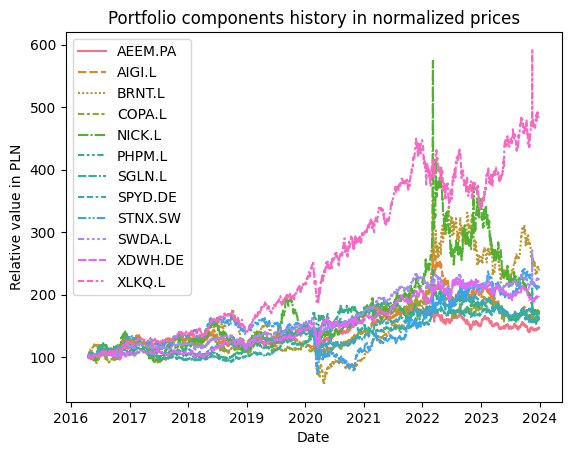

In [11]:
plot = sns.lineplot(data=etf_df)
plot.set(
    title="Portfolio components history in normalized prices",
    xlabel="Date",
    ylabel="Relative value in PLN",
)

## Evaluation of selected portfolio

Now it's time for the portfolio evaluation. We need to calculate expected yearly returns and the annualized covariance matrix.

In [12]:
mean_historical_returns = expected_returns.mean_historical_return(etf_df)
mean_historical_returns

AEEM.PA    0.054583
AIGI.L     0.067006
BRNT.L     0.125236
COPA.L     0.068690
NICK.L     0.073342
PHPM.L     0.065376
SGLN.L     0.075982
SPYD.DE    0.071229
STNX.SW    0.108479
SWDA.L     0.117902
XDWH.DE    0.097956
XLKQ.L     0.241616
dtype: float64

In [13]:
covariance_matrix = risk_models.sample_cov(etf_df)
covariance_matrix

,AEEM.PA,AIGI.L,BRNT.L,COPA.L,NICK.L,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.DE,XLKQ.L
AEEM.PA,0.038777,0.017486,0.029322,0.019648,0.022941,0.013885,0.001102,0.021593,0.024339,0.020789,0.019257,0.024345
AIGI.L,0.017486,0.051808,0.038819,0.046424,0.076534,0.025264,0.006950,0.012879,0.020768,0.012375,0.009913,0.012926
BRNT.L,0.029322,0.038819,0.148724,0.040555,0.052944,0.030543,0.004590,0.027876,0.058409,0.021471,0.018044,0.018610
COPA.L,0.019648,0.046424,0.040555,0.076939,0.049279,0.026337,0.005892,0.013699,0.021989,0.013462,0.010741,0.012864
NICK.L,0.022941,0.076534,0.052944,0.049279,0.189620,0.033792,0.012863,0.017972,0.029391,0.016313,0.014375,0.017262
PHPM.L,0.013885,0.025264,0.030543,0.026337,0.033792,0.046502,0.021335,0.008813,0.017913,0.009542,0.007708,0.009556
SGLN.L,0.001102,0.006950,0.004590,0.005892,0.012863,0.021335,0.042967,-0.000548,0.001618,0.021397,0.001259,0.022024
SPYD.DE,0.021593,0.012879,0.027876,0.013699,0.017972,0.008813,-0.000548,0.033404,0.024105,0.022082,0.022767,0.022031
STNX.SW,0.024339,0.020768,0.058409,0.021989,0.029391,0.017913,0.001618,0.024105,0.084088,0.018596,0.014425,0.014603
SWDA.L,0.020789,0.012375,0.021471,0.013462,0.016313,0.009542,0.021397,0.022082,0.018596,0.042659,0.019478,0.047642


Let's assign weights to the ETFs based on my current allocation.

In [14]:
current_weights = np.array([0, 0, 0, 0.3267, 0, 0, 0.5667, 0.1066, 0, 0, 0, 0])

Now we calculate the variance and the volatility (standard deviation) of the specified portfolio.

In [15]:
covariance_matrix

,AEEM.PA,AIGI.L,BRNT.L,COPA.L,NICK.L,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.DE,XLKQ.L
AEEM.PA,0.038777,0.017486,0.029322,0.019648,0.022941,0.013885,0.001102,0.021593,0.024339,0.020789,0.019257,0.024345
AIGI.L,0.017486,0.051808,0.038819,0.046424,0.076534,0.025264,0.006950,0.012879,0.020768,0.012375,0.009913,0.012926
BRNT.L,0.029322,0.038819,0.148724,0.040555,0.052944,0.030543,0.004590,0.027876,0.058409,0.021471,0.018044,0.018610
COPA.L,0.019648,0.046424,0.040555,0.076939,0.049279,0.026337,0.005892,0.013699,0.021989,0.013462,0.010741,0.012864
NICK.L,0.022941,0.076534,0.052944,0.049279,0.189620,0.033792,0.012863,0.017972,0.029391,0.016313,0.014375,0.017262
PHPM.L,0.013885,0.025264,0.030543,0.026337,0.033792,0.046502,0.021335,0.008813,0.017913,0.009542,0.007708,0.009556
SGLN.L,0.001102,0.006950,0.004590,0.005892,0.012863,0.021335,0.042967,-0.000548,0.001618,0.021397,0.001259,0.022024
SPYD.DE,0.021593,0.012879,0.027876,0.013699,0.017972,0.008813,-0.000548,0.033404,0.024105,0.022082,0.022767,0.022031
STNX.SW,0.024339,0.020768,0.058409,0.021989,0.029391,0.017913,0.001618,0.024105,0.084088,0.018596,0.014425,0.014603
SWDA.L,0.020789,0.012375,0.021471,0.013462,0.016313,0.009542,0.021397,0.022082,0.018596,0.042659,0.019478,0.047642


In [16]:
def assess_portfolio(weights, expected_returns, covariance_matrix):
    expected_portfolio_return = np.sum(expected_returns * weights)
    expected_portfolio_volatility = np.sqrt(weights.T @ covariance_matrix @ weights)

    return [expected_portfolio_return, expected_portfolio_volatility]


print(
    "Expected annual return: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0]
    )
)
print(
    "Expected annual volatility: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1]
    )
)

Expected annual return: 7.31%
Expected annual volatility: 15.96%


## Portfolio optimisation

Optimize for max Sharpe ratio

In [17]:
ef = EfficientFrontier(mean_historical_returns, covariance_matrix)
optimal_weights = ef.max_sharpe()
cleaned_optimal_weights = ef.clean_weights()
print(cleaned_optimal_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AEEM.PA', 0.0), ('AIGI.L', 0.0), ('BRNT.L', 0.03367), ('COPA.L', 0.0), ('NICK.L', 0.0), ('PHPM.L', 0.01475), ('SGLN.L', 0.0), ('SPYD.DE', 0.0), ('STNX.SW', 0.09301), ('SWDA.L', 0.0), ('XDWH.DE', 0.0), ('XLKQ.L', 0.85857)])
Expected annual return: 22.3%
Annual volatility: 22.8%
Sharpe Ratio: 0.89


(0.22271386558411416, 0.22750011119549118, 0.891049523091977)

Get the discrete allocation of each share per stock

In [18]:
da = DiscreteAllocation(
    cleaned_optimal_weights, latest_prices, total_portfolio_value=50000
)

allocation, leftover = da.greedy_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'XLKQ.L': 22, 'STNX.SW': 6, 'BRNT.L': 10, 'PHPM.L': 1}
Funds Remaining: 186.29 zł


Let's generate a random portfolio (i.e. a vector of non-negative numbers which sum up to one). For the details of how the function works, please see discussion in the [other notebook](random_portfolio_generator.ipynb).

In [19]:
def generate_random_weights(num_components):
    random_uniform = np.random.rand(num_components)
    random_exponential = np.log(random_uniform)
    return random_exponential / np.sum(random_exponential)

In [20]:
def generate_and_evaluate_random_portfolios(
    num_portfolios, expected_returns, covariance_matrix
):
    results = np.zeros((num_portfolios, 2))

    for i in range(num_portfolios):
        random_weights = generate_random_weights(covariance_matrix.shape[0])
        results[i, 0], results[i, 1] = assess_portfolio(
            random_weights, expected_returns, covariance_matrix
        )

    results = pd.DataFrame(results)
    results.columns = ["Annualised return", "Annualised volatility"]

    return results

In [21]:
portfolio_evaluations = generate_and_evaluate_random_portfolios(
    100_000, mean_historical_returns, covariance_matrix
)

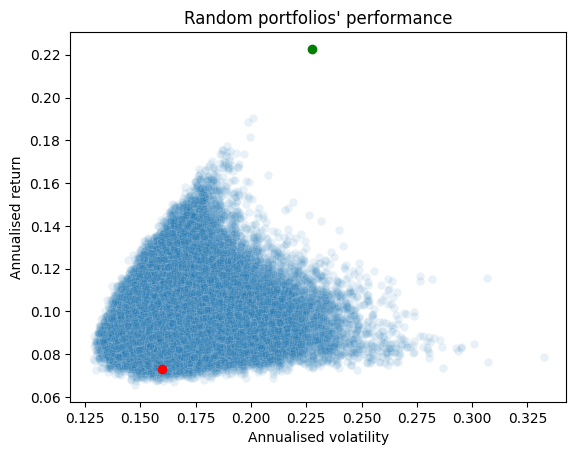

In [22]:
random_portfolios_plot = sns.scatterplot(
    data=pd.DataFrame(portfolio_evaluations),
    alpha=0.1,
    x="Annualised volatility",
    y="Annualised return",
)

random_portfolios_plot.set(title="Random portfolios' performance")

plt.scatter(
    x=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1],
    y=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0],
    color="r",
)

plt.scatter(x=ef.portfolio_performance()[1], y=ef.portfolio_performance()[0], color="g")

In [23]:
current_weights = pd.read_csv("current-weights.csv", header=None)

In [24]:
current_weights.columns = ['etf_name', 'weight_in_portfolio']
current_weights['weight_in_portfolio'].fillna(0, inplace=True)
current_weights

,etf_name,weight_in_portfolio
0,SGLN.L,3245.0
1,SWDA.L,5629.0
2,STNX.SW,0.0
3,PHPM.L,0.0
4,SPYD.DE,0.0
5,AEEM.PA,0.0
6,XDWH.DE,1059.0
7,BRNT.L,0.0
8,XLKQ.L,0.0


In [25]:
current_weights["weight_in_portfolio_normalized"] = (
    current_weights["weight_in_portfolio"]
    / current_weights["weight_in_portfolio"].sum()
)

current_weights

,etf_name,weight_in_portfolio,weight_in_portfolio_normalized
0,SGLN.L,3245.0,0.326689
1,SWDA.L,5629.0,0.566697
2,STNX.SW,0.0,0.000000
3,PHPM.L,0.0,0.000000
4,SPYD.DE,0.0,0.000000
5,AEEM.PA,0.0,0.000000
6,XDWH.DE,1059.0,0.106614
7,BRNT.L,0.0,0.000000
8,XLKQ.L,0.0,0.000000
